# Introduction

2 Notebooks ago, I published a Notebook about the technic of Seam Carving. In this Notebook, we will use this method on some images and a pre-trained metwork to check if there is benefits in the prediction for non squared images.

In [4]:
import sys
import numba
import numpy as np
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
from skimage import transform,io
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import decode_predictions

from scipy.stats import entropy
from numpy.linalg import norm

from PIL import Image
import cv2

# Preparation

Let's load 3 images of high ratio, scale them normally and with Seam Carving. This will be used for the prediction. The rest is very similar to what was done on the previous Notebook about Class Activation Map

In [10]:
def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map

@numba.jit
def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index -1
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

@numba.jit
def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((r, c), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M
    j = np.argmin(M[-1])
    
    # fill the table energy with the energy fo the best path
    if 'energy' in globals():
        global energy
        energy.append(np.min(M[-1]))
    
    for i in reversed(range(r)):
        # Mark the pixels for deletion
        mask[i, j] = False
        j = backtrack[i, j]

    # Since the image has 3 channels, we convert our
    # mask to 3D
    mask = np.stack([mask] * 3, axis=2)

    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    img = img[mask].reshape((r, c - 1, 3))

    return img


def crop_c(img, scale_c):
    r, c, _ = img.shape
    if isinstance(scale_c, float):
        new_c = int(scale_c * c)
    else:
        new_c = c-scale_c  # give a range(scale_c)

    for i in range(c - new_c):
        img = carve_column(img)

    return img

def crop_r(img, scale_r):
    img = np.rot90(img, 1, (0, 1))
    img = crop_c(img, scale_r)
    img = np.rot90(img, 3, (0, 1))
    return img

In [ ]:
test_image1 = imread("img1_original.jpg")
test_image2 = imread("img2_original.jpg")
test_image3 = imread("img3_original.jpg")
test_image4 = crop_c(test_image1, 660-281)
test_image5 = crop_c(test_image2, 870-310)
test_image6 = crop_c(test_image3, 1440-597)

In [48]:
test_image1 = transform.resize(test_image1, (299, 299))
test_image2 = transform.resize(test_image2, (299, 299))
test_image3 = transform.resize(test_image3, (299, 299))
test_image4 = transform.resize(test_image4, (299, 299))
test_image5 = transform.resize(test_image5, (299, 299))
test_image6 = transform.resize(test_image6, (299, 299))

C:\python36\envs\machine_learning\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Let's plot both pre-processed images.

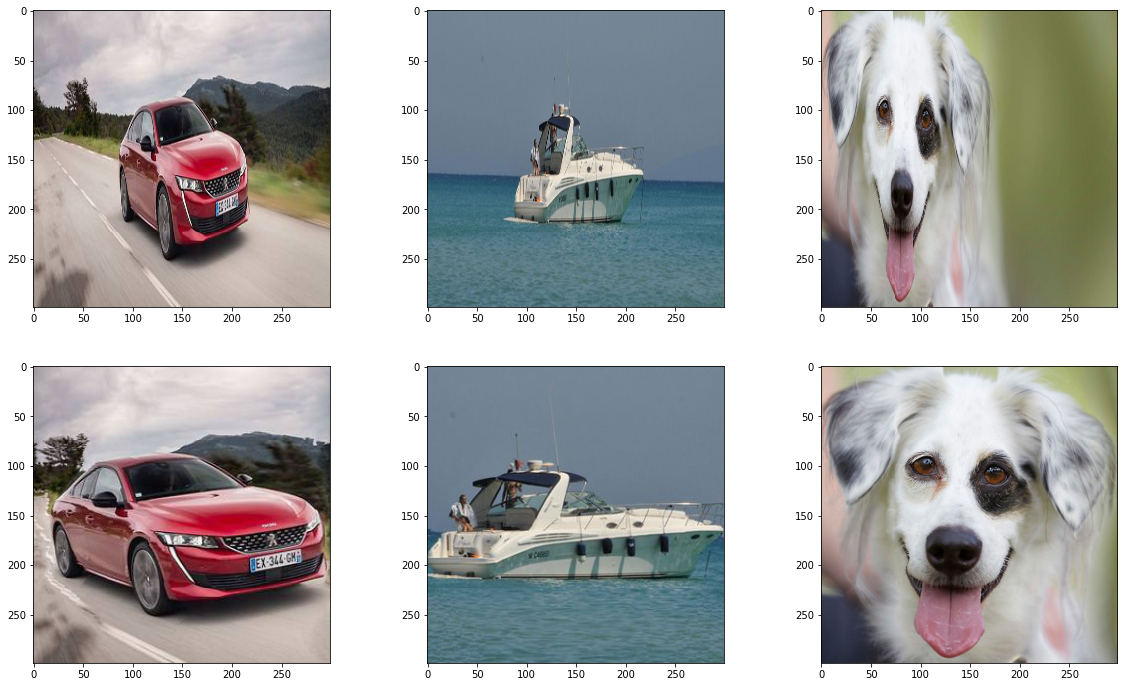

In [49]:
fig, axes = plt.subplots(2, 3, figsize=(20,12))
axes[0, 0].imshow(test_image1)
axes[0, 1].imshow(test_image2)
axes[0, 2].imshow(test_image3)
axes[1, 0].imshow(test_image4)
axes[1, 1].imshow(test_image5)
axes[1, 2].imshow(test_image6)
plt.show()

Seam Carving provides a very good result, all the background and didn't deform too much all images. We can see some artifacts on the car with the with line or with to dog where both eyes doesn't looks well aligned anymore.

Attention, I didn't divide by 255 as I used another library compatible with the Seam Carving algorithm but the result is the same (all images have pixels between 0 and 1)

In [60]:
X = np.zeros(shape=(6, 299, 299, 3), dtype=np.float32)
X[0] = np.array(test_image1)
X[1] = np.array(test_image2)
X[2] = np.array(test_image3)
X[3] = np.array(test_image4)
X[4] = np.array(test_image5)
X[5] = np.array(test_image6)
# X /= 255.0

# full prediction

We can now load the pre-trained model and make the classifications

In [63]:
IMG_SHAPE = (299, 299, 3)

base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=True, 
                                               weights='imagenet')

In [64]:
base_model.trainable = False
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_v1_94[0][0]  
__________________________________________________________________________________________________
conv2d_95 

In [65]:
y_hat = base_model.predict(X)

In [66]:
imagenet_labels = decode_predictions(y_hat, top=3)

In [67]:
print('Predicted:', imagenet_labels)

Predicted: [[('n04285008', 'sports_car', 0.60512596), ('n03459775', 'grille', 0.06157069), ('n02930766', 'cab', 0.041187916)], [('n02981792', 'catamaran', 0.6692913), ('n04606251', 'wreck', 0.1509844), ('n02704792', 'amphibian', 0.02038829)], [('n02100735', 'English_setter', 0.20691659), ('n02110341', 'dalmatian', 0.17126657), ('n02106166', 'Border_collie', 0.032139152)], [('n04285008', 'sports_car', 0.88863003), ('n04037443', 'racer', 0.023071386), ('n03459775', 'grille', 0.01118531)], [('n04273569', 'speedboat', 0.75073856), ('n04606251', 'wreck', 0.042330127), ('n02981792', 'catamaran', 0.03428451)], [('n02100735', 'English_setter', 0.2612778), ('n02106166', 'Border_collie', 0.14634384), ('n02110341', 'dalmatian', 0.06185282)]]


Let's now look at the confidence about the prediction

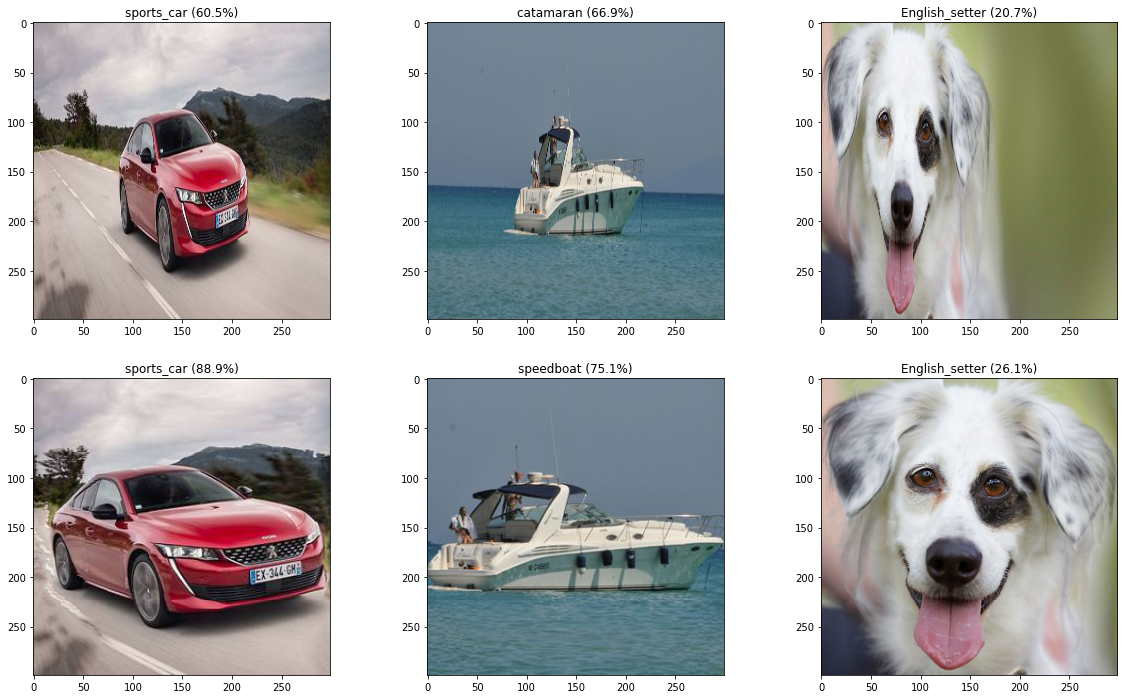

In [68]:
idx = np.argmax(y_hat, axis=1)   # imagenet label is at the end of the notebook
percent = 100*np.max(y_hat, axis=1)

fig, axes = plt.subplots(2, 3, figsize=(20,12))
axes[0, 0].imshow(test_image1)
axes[0, 0].set_title("{} ({:.1f}%)".format(imagenet_labels[0][0][1], 100*imagenet_labels[0][0][2]))
axes[0, 1].imshow(test_image2)
axes[0, 1].set_title("{} ({:.1f}%)".format(imagenet_labels[1][0][1], 100*imagenet_labels[1][0][2]))
axes[0, 2].imshow(test_image3)
axes[0, 2].set_title("{} ({:.1f}%)".format(imagenet_labels[2][0][1], 100*imagenet_labels[2][0][2]))
axes[1, 0].imshow(test_image4)
axes[1, 0].set_title("{} ({:.1f}%)".format(imagenet_labels[3][0][1], 100*imagenet_labels[3][0][2]))
axes[1, 1].imshow(test_image5)
axes[1, 1].set_title("{} ({:.1f}%)".format(imagenet_labels[4][0][1], 100*imagenet_labels[4][0][2]))
axes[1, 2].imshow(test_image6)
axes[1, 2].set_title("{} ({:.1f}%)".format(imagenet_labels[5][0][1], 100*imagenet_labels[5][0][2]))
plt.show()

In [69]:
res = decode_predictions(y_hat, top=5)
for i, row in enumerate(res):
    print("Image {}".format(i%3))
    for j, (_, label, percent) in enumerate(row):
        print("\tRank {} - {} ({:.1f}%)".format(j+1, label, 100*percent))

Image 0
	Rank 1 - sports_car (60.5%)
	Rank 2 - grille (6.2%)
	Rank 3 - cab (4.1%)
	Rank 4 - car_wheel (1.8%)
	Rank 5 - minivan (1.8%)
Image 1
	Rank 1 - catamaran (66.9%)
	Rank 2 - wreck (15.1%)
	Rank 3 - amphibian (2.0%)
	Rank 4 - liner (1.9%)
	Rank 5 - speedboat (1.6%)
Image 2
	Rank 1 - English_setter (20.7%)
	Rank 2 - dalmatian (17.1%)
	Rank 3 - Border_collie (3.2%)
	Rank 4 - Labrador_retriever (3.1%)
	Rank 5 - beagle (2.2%)
Image 3
	Rank 1 - sports_car (88.9%)
	Rank 2 - racer (2.3%)
	Rank 3 - grille (1.1%)
	Rank 4 - car_wheel (0.8%)
	Rank 5 - convertible (0.5%)
Image 4
	Rank 1 - speedboat (75.1%)
	Rank 2 - wreck (4.2%)
	Rank 3 - catamaran (3.4%)
	Rank 4 - amphibian (1.6%)
	Rank 5 - trimaran (1.4%)
Image 5
	Rank 1 - English_setter (26.1%)
	Rank 2 - Border_collie (14.6%)
	Rank 3 - dalmatian (6.2%)
	Rank 4 - collie (3.5%)
	Rank 5 - Brittany_spaniel (2.5%)


It's definitely better. The sport car took a benefit of 28% !! The other are a bit lower but there is still a huge increase (6 % for the worst one). Based on the previous notebook, let's look at the heatmap for predictions

# Heatmap

As we did previously, let's extract the Feature tensor

In [70]:
out = base_model.get_layer("mixed10").output
inp = base_model.input

get_output = tf.keras.backend.function([inp], [out])

In [71]:
conv_outputs = get_output(X)[0]
conv_outputs.shape

(6, 8, 8, 2048)

As we are using a model already trained, we can directly get the weight. In case of Transfer learning, the fit has to be done upfront.

In [72]:
class_weights = base_model.layers[-1].get_weights()[0]
class_weights.shape

(2048, 1000)

Let's now compute the heatmap for 3 images and the top 3 of classes

In [77]:
idx = np.argmax(y_hat, axis=1)

In [74]:
def get_heatmap(image_idx, label_idx):
    cam = (conv_outputs[image_idx] * class_weights[:, label_idx].reshape(1, 1, -1)).sum(axis=2)
    cam /= np.max(cam)
    cam = cv2.resize(cam, (299, 299))
    heatmap = cv2.applyColorMap(np.uint8(255*(1-cam)), cv2.COLORMAP_JET)
    heatmap[np.where(cam < 0.2)] = 0
    return heatmap

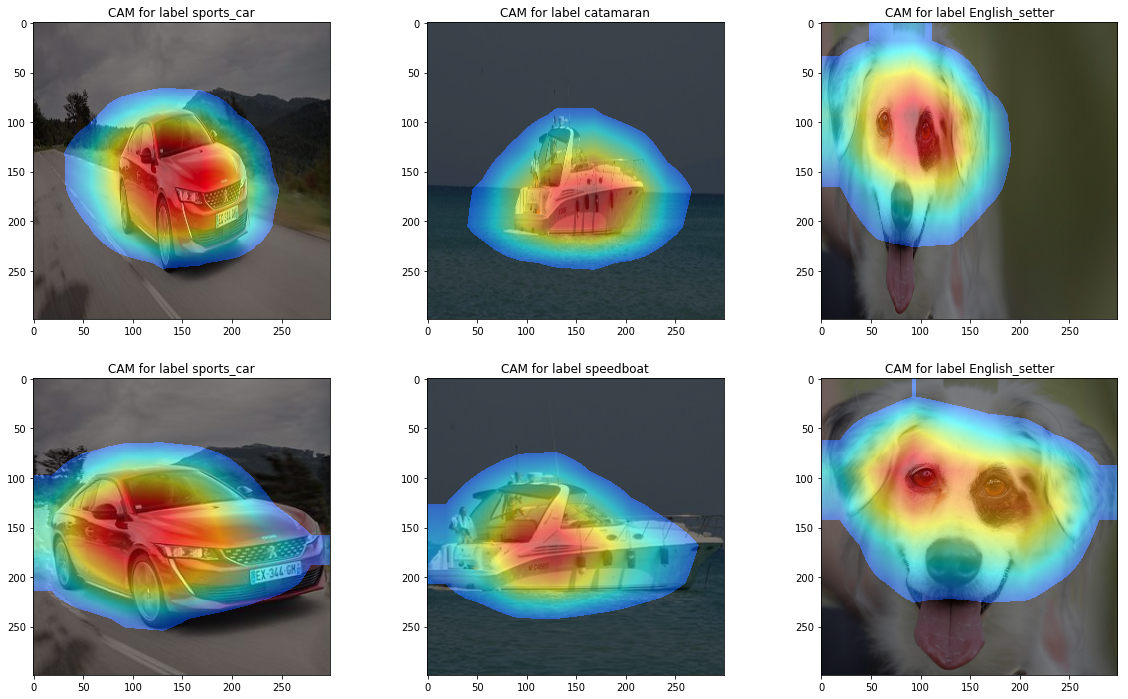

In [93]:
fig, axes = plt.subplots(2, 3, figsize=(20,12))
for image_idx in range(6):
    heatmap = get_heatmap(image_idx, idx[image_idx])
    img = 0.5 * heatmap + 0.5 * 255.0 * X[image_idx]
    pred_class = imagenet_labels[image_idx][0][1]
    axes[image_idx//3, image_idx%3].imshow(img/255.0)
    axes[image_idx//3, image_idx%3].set_title("CAM for label {}".format(pred_class))
plt.show()

Surprisingly, in both cases, the model is not using the background for the prediction. However, the confidence is higher as the interesing part is covered by more "pixels" from the feature map of 8x8. For example, with the dog, in one case, the complete face is used and in the second case, there is a particular focus on the right eye.

The seam carving algorithm works by removing lines/columns of connected pixels with the less energy. However, the more lines we remove, the more energy each line will have. We can have a quick look at how this evolves. If we remove too much lines/columns, the energy removed is important too and may create artifact. This could have a negative impact on the prediction. Let's now have a loot at how it evolves

# Energy Evolution

The energy computed will be dived by the height of the image to have an energy by rows

In [17]:
tot_energy = []

energy = []
crop_c(test_image1, test_image1.shape[1]-1)
tot_energy.append([x/test_image1.shape[0] for x in energy])

energy = []
crop_c(test_image2, test_image2.shape[1]-1)
tot_energy.append([x/test_image2.shape[0] for x in energy])

energy = []
crop_c(test_image3, test_image3.shape[1]-1)
tot_energy.append([x/test_image3.shape[0] for x in energy])

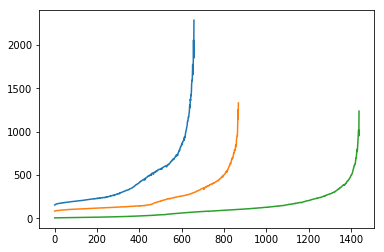

In [18]:
plt.plot(tot_energy[0])
plt.plot(tot_energy[1])
plt.plot(tot_energy[2])
plt.show()

We can see that depending on the images, the energy start to rise earlier. A trigger could be used by using the seam carving until the energy is at a specific level (or X % above the initial energy). For example, we could stop the algorithm when the blue curve reaches 250 energy par column removed (means remove around 200 pixels only). 

# Conclusion

In conclusion, I wanted to use the algorithm presented 2 notebook ago to see if this could be used to increase accuracy of prediction for images having a high ratio. Based on this simple try with few images, it seems very usefull. The next step will be to use it on a complete dataset to see if the impect is that important.